In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/timeseries-weather-dataset/Weather_Data_1980_2024(hourly).csv
/kaggle/input/timeseries-weather-dataset/Weather_dataset.csv


# EDA

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn


In [3]:
data = pd.read_csv("/kaggle/input/timeseries-weather-dataset/Weather_dataset.csv")

In [4]:
def cut_str(string):
    return string[:10]
data['time'] = data.time.apply(cut_str)


In [5]:
# преобразуем колонку с временем по часу до даты
data.time = pd.to_datetime(data.time)


In [6]:
# проведем агрегацию остальных колонк по дате
data = data.groupby("time").agg("mean")

In [7]:
data[data.columns] = data[data.columns].round(1)

In [8]:
data

,temperature,relative_humidity,dew_point,precipitation (mm),rain (mm),snowfall (cm),pressure_msl (hPa),surface_pressure (hPa),cloud_cover (%),cloud_cover_low (%),cloud_cover_mid (%),cloud_cover_high (%),vapour_pressure_deficit (kPa),wind_speed_10m (km/h),wind_direction
time,,,,,,,,,,,,,,,
2000-01-01,0.9,95.9,0.3,0.1,0.1,0.0,1022.6,1017.7,98.6,88.0,68.8,53.5,0.0,8.7,204.0
2000-01-02,3.3,94.0,2.4,0.0,0.0,0.0,1026.1,1021.3,97.1,99.9,0.8,55.7,0.0,14.0,260.9
2000-01-03,5.4,86.8,3.3,0.0,0.0,0.0,1021.9,1017.1,99.9,97.0,37.0,95.6,0.1,17.6,236.6
2000-01-04,5.4,88.5,3.6,0.2,0.2,0.0,1015.9,1011.2,99.9,100.0,88.9,70.7,0.1,15.8,224.7
2000-01-05,3.6,83.9,1.0,0.0,0.0,0.0,1018.1,1013.4,43.5,36.8,6.3,25.0,0.1,17.9,250.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,20.1,74.9,15.2,0.0,0.0,0.0,1010.2,1005.7,18.2,2.2,7.6,39.2,0.7,14.8,79.7
2024-06-02,18.8,79.2,15.0,0.4,0.4,0.0,1014.3,1009.8,43.7,22.9,11.4,57.3,0.5,16.2,318.8
2024-06-03,15.0,73.3,10.3,0.0,0.0,0.0,1016.3,1011.8,86.0,90.9,0.3,24.9,0.5,13.3,281.2


In [9]:
# Определим признаки, которые будут использоваться для обучения моделей
COLUMNS_NAMES = ["temperature", "relative_humidity", "wind_direction", "wind_speed_10m (km/h)", "dew_point"]

In [10]:
data = data[COLUMNS_NAMES]
data.reset_index(inplace = True)


In [11]:
data[data.time.dt.year == 2023]

,time,temperature,relative_humidity,wind_direction,wind_speed_10m (km/h),dew_point
8401,2023-01-01,13.9,64.5,225.2,22.2,7.1
8402,2023-01-02,11.9,75.4,222.7,18.1,7.6
8403,2023-01-03,4.8,88.6,246.3,13.4,3.1
8404,2023-01-04,7.0,88.5,220.0,24.9,5.2
8405,2023-01-05,7.5,82.8,266.0,22.0,4.7
...,...,...,...,...,...,...
8761,2023-12-27,3.8,86.3,208.7,14.9,1.7
8762,2023-12-28,8.1,71.8,226.6,22.6,3.3
8763,2023-12-29,8.9,77.7,233.1,25.2,5.2
8764,2023-12-30,6.0,84.2,243.2,19.2,3.5


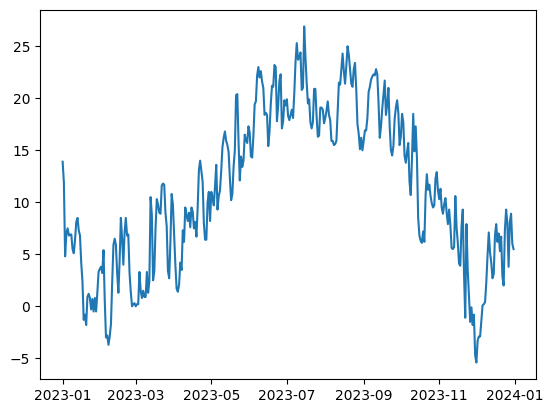

In [12]:
plt.plot(data[data.time.dt.year == 2023]["time"], data[data.time.dt.year == 2023]["temperature"])

### Видоизменим данные, чтобы каждая строка хранила информацию о предыдущих 2 неделях

In [13]:
def prepare_dataframe_for_lstm(df, n_steps):
    df = dc(df)
    df.set_index("time", inplace = True)

    for i in range(1, n_steps + 1):
        df[f"temp(t-{i})"] = df["temperature"].shift(i)
        df[f"rel_humid(t-{i})"] = df["relative_humidity"].shift(i)
        df[f"wind_d(t-{i})"] = df["wind_direction"].shift(i)
        df[f"wind_spd(t-{i})"] = df["wind_speed_10m (km/h)"].shift(i)
        df[f"dew_p(t-{i})"] = df["dew_point"].shift(i)

    df.dropna(inplace = True)

    return df

lookback = 7
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df

,temperature,relative_humidity,wind_direction,wind_speed_10m (km/h),dew_point,temp(t-1),rel_humid(t-1),wind_d(t-1),wind_spd(t-1),dew_p(t-1),...,temp(t-6),rel_humid(t-6),wind_d(t-6),wind_spd(t-6),dew_p(t-6),temp(t-7),rel_humid(t-7),wind_d(t-7),wind_spd(t-7),dew_p(t-7)
time,,,,,,,,,,,,,,,,,,,,,
2000-01-08,4.3,86.6,216.0,14.3,2.2,5.0,93.7,224.1,11.9,4.0,...,3.3,94.0,260.9,14.0,2.4,0.9,95.9,204.0,8.7,0.3
2000-01-09,4.4,92.8,275.2,7.7,3.3,4.3,86.6,216.0,14.3,2.2,...,5.4,86.8,236.6,17.6,3.3,3.3,94.0,260.9,14.0,2.4
2000-01-10,2.0,91.7,277.2,7.7,0.8,4.4,92.8,275.2,7.7,3.3,...,5.4,88.5,224.7,15.8,3.6,5.4,86.8,236.6,17.6,3.3
2000-01-11,-0.5,87.8,215.5,9.4,-2.3,2.0,91.7,277.2,7.7,0.8,...,3.6,83.9,250.5,17.9,1.0,5.4,88.5,224.7,15.8,3.6
2000-01-12,-1.5,89.1,200.0,11.7,-3.1,-0.5,87.8,215.5,9.4,-2.3,...,1.0,90.6,189.0,13.0,-0.4,3.6,83.9,250.5,17.9,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-06-01,20.1,74.9,79.7,14.8,15.2,17.7,75.3,219.1,8.4,12.9,...,18.6,80.3,143.2,7.5,15.0,18.8,76.0,133.3,7.7,14.1
2024-06-02,18.8,79.2,318.8,16.2,15.0,20.1,74.9,79.7,14.8,15.2,...,18.6,81.3,135.4,7.6,15.2,18.6,80.3,143.2,7.5,15.0
2024-06-03,15.0,73.3,281.2,13.3,10.3,18.8,79.2,318.8,16.2,15.0,...,15.5,82.2,236.6,10.5,12.3,18.6,81.3,135.4,7.6,15.2


### Теперь трансформируем данные через MinMaxScaler для оптимизации обучения

In [14]:
shifted_df_as_np = shifted_df.to_numpy()
scaler = MinMaxScaler(feature_range = (-1, 1))
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

shifted_df_as_np

array([[-0.07438017,  0.60542169,  0.23783784, ...,  0.16576577,
        -0.61494253,  0.04805492],
       [-0.07024793,  0.79216867,  0.59339339, ...,  0.50750751,
        -0.31034483,  0.14416476],
       [-0.16942149,  0.75903614,  0.60540541, ...,  0.36156156,
        -0.10344828,  0.18535469],
       ...,
       [ 0.3677686 ,  0.20481928,  0.62942943, ..., -0.24624625,
        -0.67816092,  0.72997712],
       [ 0.4214876 ,  0.18072289,  0.3027027 , ...,  0.36156156,
        -0.51149425,  0.597254  ],
       [ 0.42975207,  0.32831325,  0.38198198, ...,  0.03063063,
        -0.35057471,  0.53318078]])

### Обозначим таргеты и объекты для обучения


In [15]:
X = shifted_df_as_np[:, 5:] # первые колонки отображают текущие показания, о остальные 5 * (lookback) это значения предыдущих (lookback) показаний
y = shifted_df_as_np[:, 0] # только температура на этот день

X.shape, y.shape

((8916, 35), (8916,))

In [16]:
# преобразуем фичи и таргет для более удобно подачи в модель
X = X.reshape(-1, lookback, X.shape[1] // lookback)
y = y.reshape(-1, 1)

### TRAIN/TEST SPLIT

In [17]:
split_index = int(len(X) * 0.95)
split_index

8470

In [18]:
X_train = X[:split_index]
X_test = X[split_index:]

y_train = y[:split_index]
y_test = y[split_index:]

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((8470, 7, 5), (446, 7, 5), (8470, 1), (446, 1))

In [19]:
X_train = torch.tensor(X_train).float()
y_train = torch.tensor(y_train).float()
X_test = torch.tensor(X_test).float()
y_test = torch.tensor(y_test).float()

X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([8470, 7, 5]),
 torch.Size([446, 7, 5]),
 torch.Size([8470, 1]),
 torch.Size([446, 1]))

### Creating Dataset

In [20]:
# Determine the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [21]:
from torch.utils.data import Dataset

class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, i):
        return self.X[i], self.y[i]

train_dataset = TimeSeriesDataset(X_train, y_train)
test_dataset = TimeSeriesDataset(X_test, y_test)

In [22]:
from torch.utils.data import DataLoader

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [23]:
for _, batch in enumerate(train_loader):
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)
    print(x_batch.shape, y_batch.shape)
    break

torch.Size([16, 7, 5]) torch.Size([16, 1])


### LSTM MODEL

In [24]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_stacked_layers = num_stacked_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers,
                            batch_first = True)
        self.fc = nn.Linear(hidden_size, 1)


    def forward(self, x):
        batch_size = x.size(0)
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

model = LSTM(X.shape[2], 4, 1)
model.to(device)
model

LSTM(
  (lstm): LSTM(5, 4, batch_first=True)
  (fc): Linear(in_features=4, out_features=1, bias=True)
)

In [25]:
X.shape

(8916, 7, 5)

### LSTM TRAINING PROCESS

In [26]:
def train_one_epoch(model):
    model.train(True)
    print(f"Epoch: {epoch + 1}")
    running_loss = 0.0

    for batch_index, batch in enumerate(train_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        output = model(x_batch)
        loss = loss_function(output, y_batch)
        running_loss += loss.item()
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_index % 100 == 99: # выводим каждые 100 батчей
            avg_loss_across_batches = running_loss / 100
            print("Batch {0}, Loss: {1:.3f}".format(batch_index + 1,
                                                avg_loss_across_batches))
            running_loss = 0.0
    print()

In [27]:
def validate_one_epoch(model):
    model.train(False)
    running_loss = 0.0

    for batch_index, batch in enumerate(test_loader):
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        with torch.no_grad():
            output = model(x_batch)
            loss = loss_function(output, y_batch)
            running_loss += loss

    avg_loss_across_batches = running_loss / len(test_loader)

    print("Val Loss: {0:.3f}".format(avg_loss_across_batches))
    print("****************************************************")
    print()

In [28]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(model)
    validate_one_epoch(model)

Epoch: 1
Batch 100, Loss: 0.545
Batch 200, Loss: 0.245
Batch 300, Loss: 0.087
Batch 400, Loss: 0.051
Batch 500, Loss: 0.029

Val Loss: 0.023
****************************************************

Epoch: 2
Batch 100, Loss: 0.023
Batch 200, Loss: 0.021
Batch 300, Loss: 0.021
Batch 400, Loss: 0.021
Batch 500, Loss: 0.020

Val Loss: 0.022
****************************************************

Epoch: 3
Batch 100, Loss: 0.019
Batch 200, Loss: 0.020
Batch 300, Loss: 0.020
Batch 400, Loss: 0.019
Batch 500, Loss: 0.018

Val Loss: 0.020
****************************************************

Epoch: 4
Batch 100, Loss: 0.019
Batch 200, Loss: 0.019
Batch 300, Loss: 0.018
Batch 400, Loss: 0.018
Batch 500, Loss: 0.018

Val Loss: 0.019
****************************************************

Epoch: 5
Batch 100, Loss: 0.018
Batch 200, Loss: 0.016
Batch 300, Loss: 0.016
Batch 400, Loss: 0.018
Batch 500, Loss: 0.018

Val Loss: 0.018
****************************************************

Epoch: 6
Batch 100, Loss:

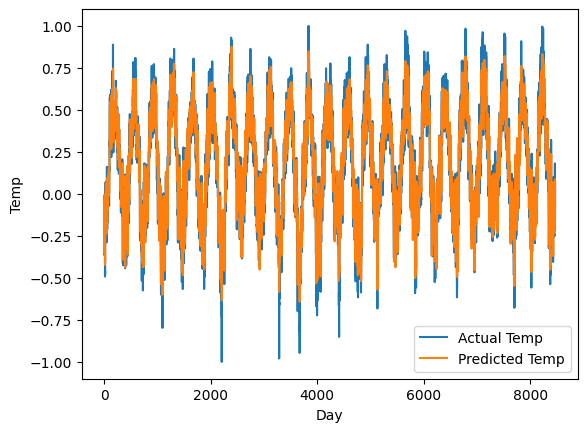

In [29]:
with torch.no_grad():
    predicted = model(X_train.to(device)).to("cpu").numpy()

plt.plot(y_train, label = "Actual Temp")
plt.plot(predicted, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

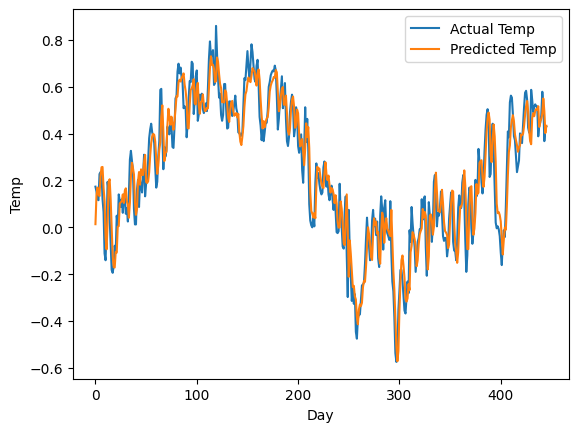

In [30]:
with torch.no_grad():
    predicted_test = model(X_test.to(device)).to("cpu").numpy()

plt.plot(y_test, label = "Actual Temp")
plt.plot(predicted_test, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [31]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([4.49958302, 4.79327524, 5.16569254, ..., 8.16682822, 4.27037763,
       4.29267547])

In [32]:
dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([4.29999996, 4.40000001, 1.99999985, ..., 2.49999993, 3.40000003,
       7.50000001])

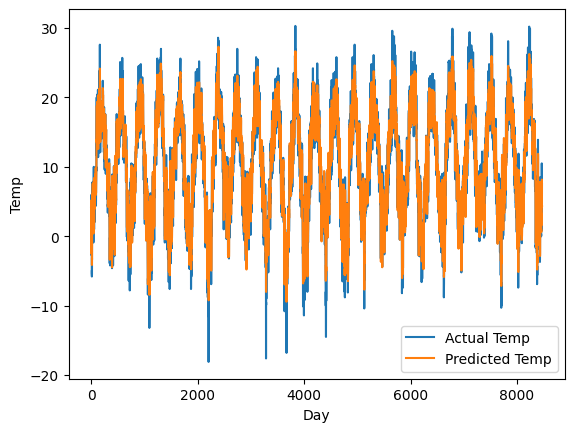

In [33]:
plt.plot(new_y_train, label = "Actual Temp")
plt.plot(train_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [34]:
test_predictions = model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 6.4246497 ,  9.36173778, 10.20714308,  9.47900753,  9.32528607,
       11.34748687, 12.30269301, 12.33814079, 10.1863158 ,  8.80174946,
        5.07415145,  3.82923781,  6.61695119, 10.77190008, 11.06519707,
        9.01206187,  5.98005021,  3.20421742,  1.98381287,  1.95128169,
        3.56397232,  3.48591293,  6.16878744,  6.23234462,  8.56021199,
        8.6759845 ,  8.80651814,  9.49547001,  8.61962145,  9.88979064,
       10.1294955 ,  8.75776536,  8.45337462,  7.09061281,  8.65132034,
       11.32186782, 12.76647542, 12.23709695, 11.55559524,  8.72322848,
        7.39456145,  7.97366776, 10.82769337, 11.80721315, 10.50233399,
       12.08632382, 11.51756119, 11.51004179, 12.90959644, 13.57998998,
       10.79583292, 10.67909542, 10.84708687, 11.7724087 , 13.49570721,
       14.79310592, 15.51658963, 15.74770336, 15.65322115, 14.95194947,
       13.12127051, 11.62066625, 12.47614839, 14.09813045, 14.88036731,
       17.53866926, 18.70204581, 16.02037934, 12.93981252, 13.80

In [35]:
dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([10.30000003,  9.79999995,  9.00000007,  8.90000002, 11.60000016,
       11.79999991, 11.70000004,  9.00000007,  7.69999993,  3.40000003,
        2.70000003,  6.2       , 10.80000011,  9.79999995,  7.00000002,
        3.99999999,  1.69999987,  1.39999989,  2.10000008,  4.19999991,
        3.50000009,  7.29999999,  6.2       ,  9.49999997,  8.79999997,
        8.20000001,  9.00000007,  7.59999997,  9.49999997,  9.09999994,
        7.50000001,  8.09999996,  6.7       ,  9.49999997, 13.09999968,
       14.00000033, 13.00000017, 12.00000001,  8.00000009,  6.4       ,
        6.4       , 10.00000005, 10.99999985,  8.20000001, 10.99999985,
       10.50000013,  9.70000007, 11.49999993, 13.60000013,  9.29999987,
       10.6       , 11.10000008, 13.00000017, 15.29999975, 16.19999968,
       16.80000035, 15.8999997 , 15.50000021, 14.80000003, 12.29999999,
       10.20000015, 10.80000011, 13.39999966, 14.99999977, 20.29999983,
       20.39999934, 15.80000019, 12.09999988, 14.39999982, 13.39

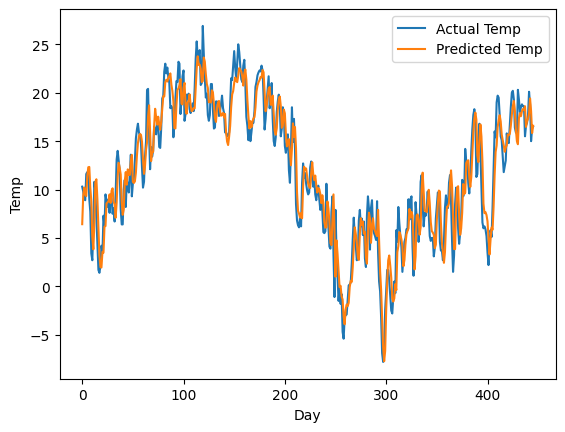

In [36]:
plt.plot(new_y_test, label = "Actual Temp")
plt.plot(test_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

# Результаты LSTM Модели

In [37]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)

# Assuming you have:
# test_predictions = np.array([...])  # Your model's predictions
# new_y_test = np.array([...])        # Ground truth values

def print_regression_metrics(y_true, y_pred):
    """Prints comprehensive regression metrics."""
    print("Regression Metrics:")
    print("------------------")
    print(f"1. MAE (Mean Absolute Error): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"2. MSE (Mean Squared Error): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"3. RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"4. R² Score (Coefficient of Determination): {r2_score(y_true, y_pred):.4f}")
    print(f"5. Explained Variance Score: {explained_variance_score(y_true, y_pred):.4f}")
    print(f"6. MAPE (Mean Absolute Percentage Error): {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    print(f"7. Max Error: {np.max(np.abs(y_true - y_pred)):.4f}")

# Calculate and print metrics
print_regression_metrics(new_y_test, test_predictions)

Regression Metrics:
------------------
1. MAE (Mean Absolute Error): 1.8171
2. MSE (Mean Squared Error): 5.3328
3. RMSE (Root Mean Squared Error): 2.3093
4. R² Score (Coefficient of Determination): 0.8921
5. Explained Variance Score: 0.8923
6. MAPE (Mean Absolute Percentage Error): 0.3693
7. Max Error: 6.9076


## TRANSFORMER SOLUTION

### POSITIONAL ENCODING

In [38]:
import math

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        # Initialize positional encoding matrix
        pe = torch.zeros(max_len, d_model)  # Shape: [max_len, d_model]
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)  # [max_len, 1]
        
        # Compute the divisor term for sinusoidal functions
        div_term = torch.exp(
            torch.arange(0, d_model, 2).float() * 
            (-math.log(10000.0) / d_model)  # Use math.log instead of np.log
        )  # Shape: [d_model // 2]
        
        # Fill even indices with sine, odd indices with cosine
        pe[:, 0::2] = torch.sin(position * div_term)  # Even positions
        pe[:, 1::2] = torch.cos(position * div_term)  # Odd positions
        
        # Reshape for batch-first input: [1, max_len, d_model]
        pe = pe.unsqueeze(0)  # Add batch dimension (no transpose needed)
        self.register_buffer('pe', pe)

    def forward(self, x):
        """
        Args:
            x: Input tensor of shape [batch_size, seq_len, d_model]
        Returns:
            x + positional encoding (same shape as input)
        """
        # Add positional encoding to the input
        # Slice positional encoding to match the sequence length of `x`
        x = x + self.pe[:, :x.size(1), :]  # pe[:, :seq_len, :]
        return self.dropout(x)

### TRANSFORMER CONSTRUCTION

In [39]:
import torch
import torch.nn as nn

class TransformerModel(nn.Module):
    def __init__(self, input_dim=5, d_model=64, nhead=4, num_layers=2, dropout=0.2):
        super(TransformerModel, self).__init__()
        
        # 1. Project input features to `d_model` dimension
        self.encoder = nn.Linear(input_dim, d_model)
        
        # 2. Add positional encoding (already modified for batch-first inputs)
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        
        # 3. Transformer encoder layers (PyTorch expects seq-first by default)
        encoder_layers = nn.TransformerEncoderLayer(
            d_model=d_model, 
            nhead=nhead, 
            dropout=dropout, 
            batch_first=False  # Set to False (default) since we permute dimensions
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layers, num_layers)
        
        # 4. Decoder to predict the target (single value)
        self.decoder = nn.Linear(d_model, 1)

    def forward(self, x):
        # Input shape: [batch_size, seq_len=7, input_dim=5]
        
        # Step 1: Project input to `d_model`
        x = self.encoder(x)  # Output shape: [batch_size, 7, d_model]
        
        # Step 2: Add positional encoding
        x = self.pos_encoder(x)  # Shape remains [batch_size, 7, d_model]
        
        # Step 3: Adjust dimensions for Transformer (seq-first format)
        x = x.permute(1, 0, 2)  # New shape: [7, batch_size, d_model]
        
        # Step 4: Pass through Transformer encoder
        x = self.transformer_encoder(x)  # Output shape: [7, batch_size, d_model]
        
        # Step 5: Revert to batch-first format
        x = x.permute(1, 0, 2)  # New shape: [batch_size, 7, d_model]
        
        # Step 6: Use only the last timestep for prediction
        x = self.decoder(x[:, -1, :])  # Output shape: [batch_size, 1]
        
        return x

# Initialize model with input_dim=5 (matches your X.shape[2])
transformer_model = TransformerModel(input_dim=5).to(device)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
learning_rate = 0.001
num_epochs = 20
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(transformer_model.parameters(), lr = learning_rate)

for epoch in range(num_epochs):
    train_one_epoch(transformer_model)
    validate_one_epoch(transformer_model)

Epoch: 1
Batch 100, Loss: 0.216
Batch 200, Loss: 0.033
Batch 300, Loss: 0.023
Batch 400, Loss: 0.019
Batch 500, Loss: 0.016

Val Loss: 0.013
****************************************************

Epoch: 2
Batch 100, Loss: 0.015
Batch 200, Loss: 0.015
Batch 300, Loss: 0.013
Batch 400, Loss: 0.014
Batch 500, Loss: 0.013

Val Loss: 0.012
****************************************************

Epoch: 3
Batch 100, Loss: 0.013
Batch 200, Loss: 0.013
Batch 300, Loss: 0.012
Batch 400, Loss: 0.011
Batch 500, Loss: 0.012

Val Loss: 0.011
****************************************************

Epoch: 4
Batch 100, Loss: 0.012
Batch 200, Loss: 0.013
Batch 300, Loss: 0.011
Batch 400, Loss: 0.011
Batch 500, Loss: 0.011

Val Loss: 0.010
****************************************************

Epoch: 5
Batch 100, Loss: 0.011
Batch 200, Loss: 0.013
Batch 300, Loss: 0.012
Batch 400, Loss: 0.012
Batch 500, Loss: 0.011

Val Loss: 0.012
****************************************************

Epoch: 6
Batch 100, Loss:

### PLOTTING RESULTS

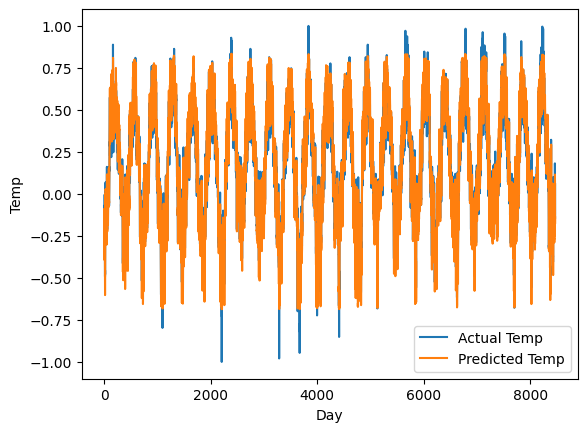

In [41]:
with torch.no_grad():
    predicted = transformer_model(X_train.to(device)).to("cpu").numpy()

plt.plot(y_train, label = "Actual Temp")
plt.plot(predicted, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

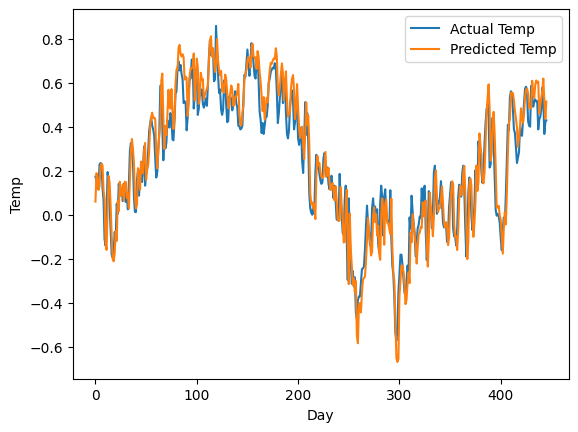

In [42]:
with torch.no_grad():
    predicted_test = transformer_model(X_test.to(device)).to("cpu").numpy()

plt.plot(y_test, label = "Actual Temp")
plt.plot(predicted_test, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [43]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([3.87843845, 3.29625182, 3.45836355, ..., 7.71463611, 1.79822122,
       2.74050497])

In [44]:
dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([4.29999996, 4.40000001, 1.99999985, ..., 2.49999993, 3.40000003,
       7.50000001])

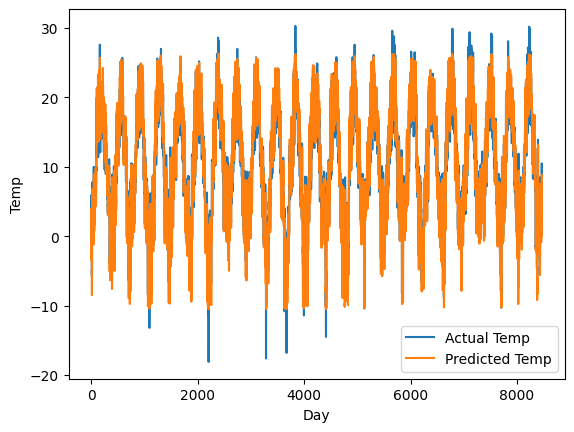

In [45]:
plt.plot(new_y_train, label = "Actual Temp")
plt.plot(train_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [46]:
test_predictions = transformer_model(X_test.to(device)).detach().cpu().numpy().flatten()

dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([  7.54475896,  10.67517489,  10.26348882,   8.8431103 ,
         9.22711087,  11.44607964,  11.71719816,  11.52684071,
         8.77035744,   7.82203783,   2.9615224 ,   2.22860447,
         6.76533529,  10.3646127 ,   9.59556833,   7.06164678,
         3.88313177,   1.19791511,   0.96428289,   1.83766165,
         4.29040689,   3.22215551,   7.5998972 ,   6.4834748 ,
         9.73798112,   8.35463634,   8.20945317,   9.42321569,
         7.62375097,   9.73299932,   9.68961023,   7.94426017,
         8.44218099,   6.81178675,  10.02138627,  13.18241234,
        14.44149067,  13.35068073,  11.81194072,   8.03634037,
         6.80033095,   7.24247426,  11.23064768,  10.89792901,
         8.84134423,  11.95151661,  10.6512197 ,  10.71614935,
        13.24347267,  14.00470266,   9.92699097,  11.1504881 ,
        11.53542715,  13.10243018,  15.82720663,  16.81718693,
        17.34678897,  16.72361057,  16.81449896,  16.62626442,
        13.13865182,  11.21501387,  13.01256304,  15.01

In [47]:
dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([10.30000003,  9.79999995,  9.00000007,  8.90000002, 11.60000016,
       11.79999991, 11.70000004,  9.00000007,  7.69999993,  3.40000003,
        2.70000003,  6.2       , 10.80000011,  9.79999995,  7.00000002,
        3.99999999,  1.69999987,  1.39999989,  2.10000008,  4.19999991,
        3.50000009,  7.29999999,  6.2       ,  9.49999997,  8.79999997,
        8.20000001,  9.00000007,  7.59999997,  9.49999997,  9.09999994,
        7.50000001,  8.09999996,  6.7       ,  9.49999997, 13.09999968,
       14.00000033, 13.00000017, 12.00000001,  8.00000009,  6.4       ,
        6.4       , 10.00000005, 10.99999985,  8.20000001, 10.99999985,
       10.50000013,  9.70000007, 11.49999993, 13.60000013,  9.29999987,
       10.6       , 11.10000008, 13.00000017, 15.29999975, 16.19999968,
       16.80000035, 15.8999997 , 15.50000021, 14.80000003, 12.29999999,
       10.20000015, 10.80000011, 13.39999966, 14.99999977, 20.29999983,
       20.39999934, 15.80000019, 12.09999988, 14.39999982, 13.39

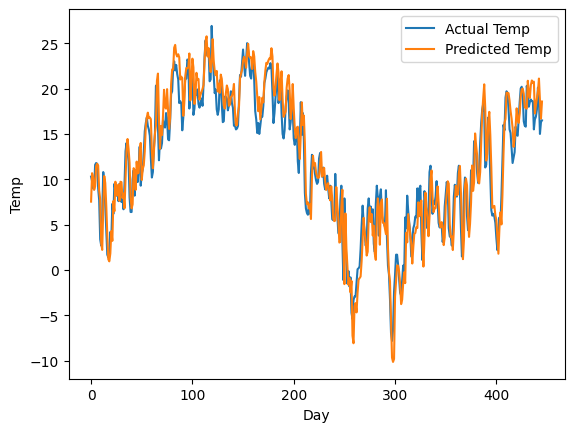

In [48]:
plt.plot(new_y_test, label = "Actual Temp")
plt.plot(test_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

# РЕЗУЛЬТАТЫ TRANSFORMER МОДЕЛИ

In [50]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)

# Assuming you have:
# test_predictions = np.array([...])  # Your model's predictions
# new_y_test = np.array([...])        # Ground truth values

def print_regression_metrics(y_true, y_pred):
    """Prints comprehensive regression metrics."""
    print("Regression Metrics:")
    print("------------------")
    print(f"1. MAE (Mean Absolute Error): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"2. MSE (Mean Squared Error): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"3. RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"4. R² Score (Coefficient of Determination): {r2_score(y_true, y_pred):.4f}")
    print(f"5. Explained Variance Score: {explained_variance_score(y_true, y_pred):.4f}")
    print(f"6. MAPE (Mean Absolute Percentage Error): {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    print(f"7. Max Error: {np.max(np.abs(y_true - y_pred)):.4f}")

# Calculate and print metrics
print("------------------------------TRANSFORMER MODEL-----------------------------------")
print_regression_metrics(new_y_test, test_predictions)

Regression Metrics:
------------------
1. MAE (Mean Absolute Error): 1.8769
2. MSE (Mean Squared Error): 5.7605
3. RMSE (Root Mean Squared Error): 2.4001
4. R² Score (Coefficient of Determination): 0.8834
5. Explained Variance Score: 0.8863
6. MAPE (Mean Absolute Percentage Error): 0.3998
7. Max Error: 9.4440


### ОБУЧИМ ДЛЯ СРАВНЕНИЯ ЛИНЕЙНУЮ РЕГРЕССИЮ

In [56]:
y_train.shape

torch.Size([8470, 1])

In [58]:
from sklearn.linear_model import Ridge

ridge_model = Ridge(alpha=0.5)  # alpha — сила регуляризации
ridge_model.fit(X_train.reshape(-1, 35), y_train)


Ridge(alpha=0.5)

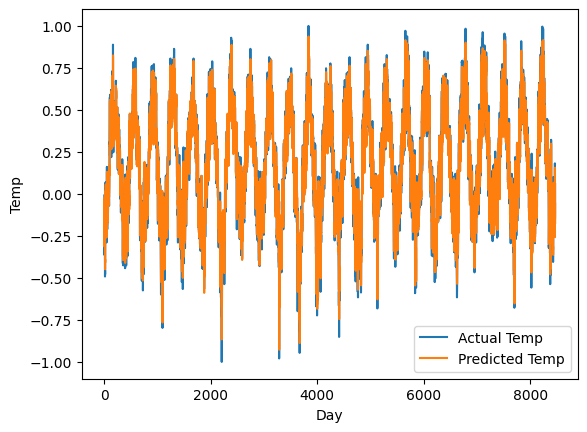

In [60]:

predicted = ridge_model.predict(X_train.reshape(-1, 35))

plt.plot(y_train, label = "Actual Temp")
plt.plot(predicted, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

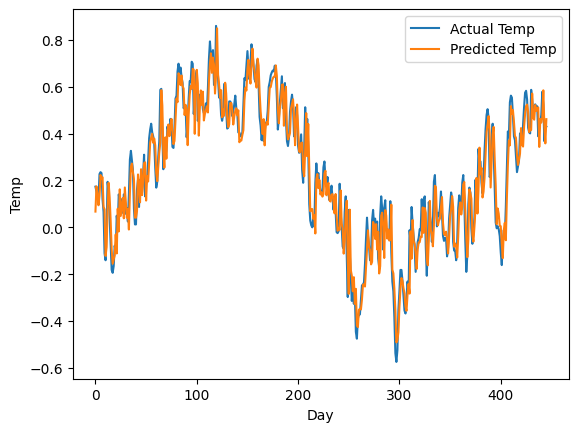

In [61]:

predicted_test = ridge_model.predict(X_test.reshape(-1, 35))
plt.plot(y_test, label = "Actual Temp")
plt.plot(predicted_test, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [62]:
train_predictions = predicted.flatten()

dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

train_predictions = dc(dummies[:, 0])
train_predictions

array([5.47984119, 3.54858613, 4.49564239, ..., 6.32441837, 1.77705342,
       4.69231304])

In [63]:
dummies = np.zeros((X_train.shape[0], 40))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_train = dc(dummies[:, 0])
new_y_train

array([4.29999996, 4.40000001, 1.99999985, ..., 2.49999993, 3.40000003,
       7.50000001])

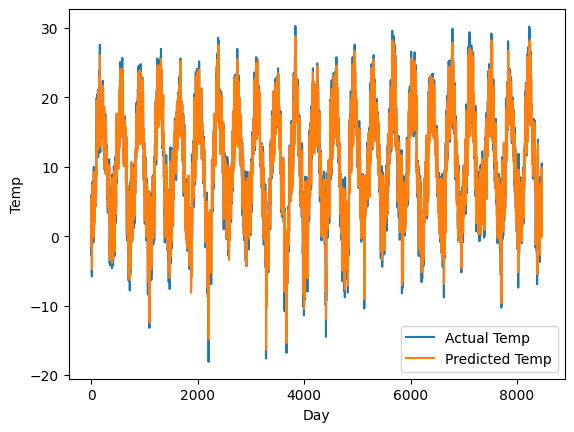

In [64]:
plt.plot(new_y_train, label = "Actual Temp")
plt.plot(train_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

In [66]:
test_predictions = ridge_model.predict(X_test.reshape(-1, 35)).flatten()

dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

test_predictions = dc(dummies[:, 0])
test_predictions

array([ 7.72556712e+00,  1.03304297e+01,  9.58567214e+00,  8.37972305e+00,
        9.35191553e+00,  1.15004241e+01,  1.11248100e+01,  1.12737432e+01,
        8.20548104e+00,  7.95404170e+00,  3.15311085e+00,  4.04488888e+00,
        7.97375060e+00,  1.06966066e+01,  9.20864911e+00,  6.76736165e+00,
        3.81535965e+00,  2.33915458e+00,  2.76013382e+00,  3.21966746e+00,
        5.36326999e+00,  3.40328524e+00,  8.02219156e+00,  5.67388932e+00,
        1.00240034e+01,  7.28254064e+00,  8.23979157e+00,  9.13497670e+00,
        7.03166702e+00,  1.02189290e+01,  8.57138880e+00,  7.08528339e+00,
        8.02488103e+00,  5.87345451e+00,  9.66043463e+00,  1.23416834e+01,
        1.26783581e+01,  1.17761757e+01,  1.10664624e+01,  7.10329077e+00,
        7.10050487e+00,  7.78329541e+00,  1.15597425e+01,  1.03476863e+01,
        8.68505286e+00,  1.21006448e+01,  9.42574936e+00,  1.08423854e+01,
        1.27238873e+01,  1.28130053e+01,  8.86340780e+00,  1.13775237e+01,
        1.08338671e+01,  

In [67]:
dummies = np.zeros((X_test.shape[0], 40))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

new_y_test = dc(dummies[:, 0])
new_y_test

array([10.30000003,  9.79999995,  9.00000007,  8.90000002, 11.60000016,
       11.79999991, 11.70000004,  9.00000007,  7.69999993,  3.40000003,
        2.70000003,  6.2       , 10.80000011,  9.79999995,  7.00000002,
        3.99999999,  1.69999987,  1.39999989,  2.10000008,  4.19999991,
        3.50000009,  7.29999999,  6.2       ,  9.49999997,  8.79999997,
        8.20000001,  9.00000007,  7.59999997,  9.49999997,  9.09999994,
        7.50000001,  8.09999996,  6.7       ,  9.49999997, 13.09999968,
       14.00000033, 13.00000017, 12.00000001,  8.00000009,  6.4       ,
        6.4       , 10.00000005, 10.99999985,  8.20000001, 10.99999985,
       10.50000013,  9.70000007, 11.49999993, 13.60000013,  9.29999987,
       10.6       , 11.10000008, 13.00000017, 15.29999975, 16.19999968,
       16.80000035, 15.8999997 , 15.50000021, 14.80000003, 12.29999999,
       10.20000015, 10.80000011, 13.39999966, 14.99999977, 20.29999983,
       20.39999934, 15.80000019, 12.09999988, 14.39999982, 13.39

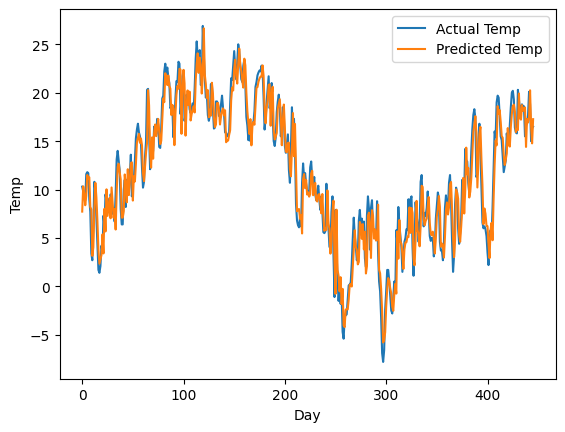

In [68]:
plt.plot(new_y_test, label = "Actual Temp")
plt.plot(test_predictions, label = "Predicted Temp")
plt.xlabel("Day")
plt.ylabel("Temp")
plt.legend()
plt.show()

# РЕЗУЛЬТАТЫ ЛИНЕЙНОЙ МОДЕЛИ

In [71]:
from sklearn.metrics import (
    mean_absolute_error,
    mean_squared_error,
    r2_score,
    explained_variance_score,
    mean_absolute_percentage_error
)

# Assuming you have:
# test_predictions = np.array([...])  # Your model's predictions
# new_y_test = np.array([...])        # Ground truth values

def print_regression_metrics(y_true, y_pred):
    """Prints comprehensive regression metrics."""
    print("Regression Metrics:")
    print("------------------")
    print(f"1. MAE (Mean Absolute Error): {mean_absolute_error(y_true, y_pred):.4f}")
    print(f"2. MSE (Mean Squared Error): {mean_squared_error(y_true, y_pred):.4f}")
    print(f"3. RMSE (Root Mean Squared Error): {np.sqrt(mean_squared_error(y_true, y_pred)):.4f}")
    print(f"4. R² Score (Coefficient of Determination): {r2_score(y_true, y_pred):.4f}")
    print(f"5. Explained Variance Score: {explained_variance_score(y_true, y_pred):.4f}")
    print(f"6. MAPE (Mean Absolute Percentage Error): {mean_absolute_percentage_error(y_true, y_pred):.4f}")
    print(f"7. Max Error: {np.max(np.abs(y_true - y_pred)):.4f}")

# Calculate and print metrics
print("------------------------LINEAR REGRESSION--------------------------")
print_regression_metrics(new_y_test, test_predictions)

------------------------LINEAR REGRESSION--------------------------
Regression Metrics:
------------------
1. MAE (Mean Absolute Error): 1.5875
2. MSE (Mean Squared Error): 4.1120
3. RMSE (Root Mean Squared Error): 2.0278
4. R² Score (Coefficient of Determination): 0.9168
5. Explained Variance Score: 0.9179
6. MAPE (Mean Absolute Percentage Error): 0.2922
7. Max Error: 8.6744


# Сравнение показателей наглядно

### LINEAR MODEL ->
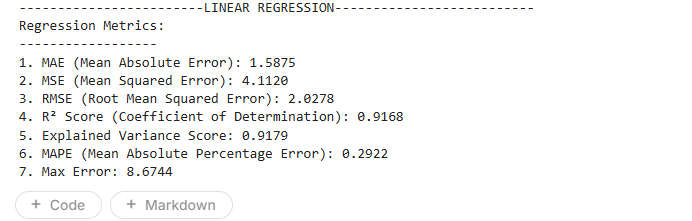
### TRANSFOMER MODEL ->
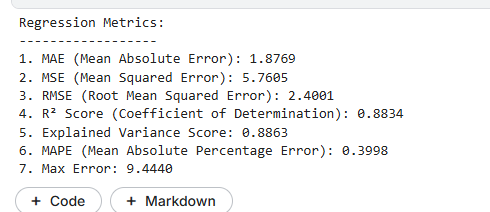
### LSTM MODEL ->
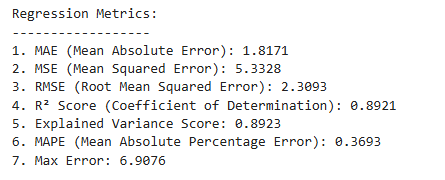